In [ ]:
# what I want to do is play with outliers, and also move threshold of original model

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve,
                             confusion_matrix,precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay)
from scipy.stats.mstats import winsorize


In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [4]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [5]:
def get_preds(classifier, X_test, y_test, threshold):
    y_preds = classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds = 1 * (y_preds > threshold)
    return y_preds    

In [6]:
def find_threshold(estimator, X_train, y_train, scoring='f1'):
    best_thresholds=[0]*5
    scores = cross_validate(estimator, X_train, y_train, scoring = scoring, return_estimator=True)
    for i in range(5):
        estimator_i = scores['estimator'][i]
        yhat = estimator_i.predict_proba(X_train)
        yhat = yhat[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train,yhat)
        fscores = 2*precision*recall/(precision+recall)
        ix = np.argmax(fscores)
        best_thresholds[i] = thresholds[ix]
    return np.mean(best_thresholds)

In [7]:
def print_accuracy_results(y_true, y_preds):
    correct_classification = 1 - np.absolute(y_true - y_preds)
    scores_df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = scores_df[scores_df.y_values == 0]
    ones = scores_df[scores_df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [8]:
def print_scores(classifier, X_test, y_test, threshold=None, beta=1.0):
    if threshold is None:
        y_preds = classifier.predict(X_test)
    else:
        y_preds = get_preds(classifier, X_test, y_test, threshold)
        
    scores = precision_recall_fscore_support(y_preds, y_test, beta=beta, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    print('-'*50)
    print_accuracy_results(y_test, y_preds)

# Splitting the data

In [9]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [62]:
numeric_features = X.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(drop = 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression())])

In [63]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier', LogisticRegression())])

In [64]:
print_scores(lr1, X_test, y_test)

precision score:  0.9907235621521335
recall score:  0.8476190476190476
f1 score:  0.913601368691189
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.07235621521336
The percentage of not fully_paid predicted correctly:  3.678929765886288


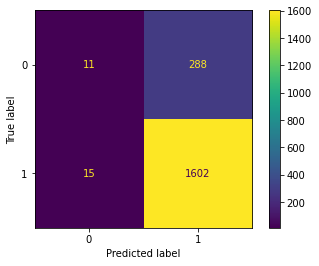

In [65]:
plot_confusion_matrix(lr1, X_test, y_test)

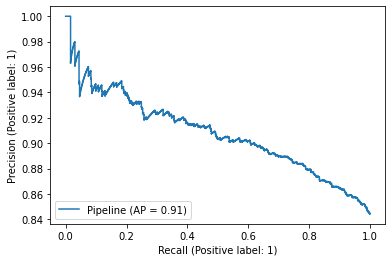

In [40]:
plot_precision_recall_curve(lr1, X_test, y_test)

# Logistic Regression Models with selected features

From the exploratory data analysis, I feel the following four features may effect whether a loan is fully paid.

In [66]:
X2 = df[['credit_policy','purpose','int_rate','revol_util']]
X2_train, X2_test = train_test_split(X2, random_state=675, test_size=0.2)

In [67]:
numeric_features = X2.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(drop = 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

lr2 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression(solver='saga',penalty='none'))])

In [68]:
lr2.fit(X2_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier',
                 LogisticRegression(penalty='none', solver='saga'))])

In [69]:
print_scores(lr2, X2_test, y_test)

precision score:  0.9987631416202845
recall score:  0.8455497382198953
f1 score:  0.9157924581797562
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.87631416202845
The percentage of not fully_paid predicted correctly:  1.3377926421404682


Choosing parameters only increased the f1 by a very small amount.  The accuracy decreased.  I want to try regulariztion to avoid overfitting instead of manually selecting features.

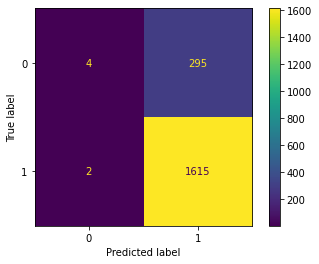

In [70]:
plot_confusion_matrix(lr2 ,X2_test, y_test)

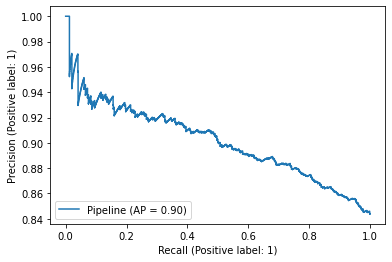

In [71]:
plot_precision_recall_curve(lr2 ,X2_test, y_test)

# Using balanced class weights and regularization

In [47]:
lr3 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression(solver='saga', class_weight='balanced'))])

In [48]:
lr3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [49]:
print_scores(lr3, X_test, y_test)

precision score:  0.6648113790970934
recall score:  0.8876961189099918
f1 score:  0.7602545968882604
--------------------------------------------------
The percentage of fully_paid predicted correctly:  66.48113790970933
The percentage of not fully_paid predicted correctly:  54.51505016722408


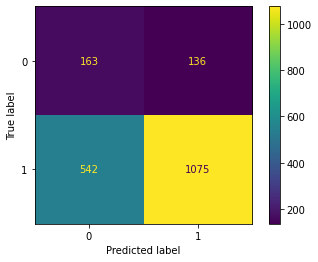

In [50]:
plot_confusion_matrix(lr3 ,X_test, y_test)

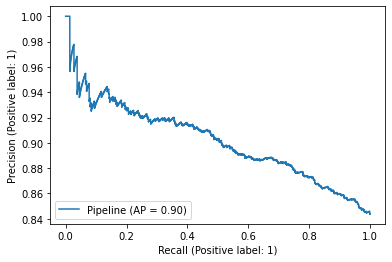

In [51]:
plot_precision_recall_curve(lr3 ,X_test, y_test)

With balanced class weights, more true negatives are predicted but f1 score drops.

# Handling outliers

In [74]:
X3_train = X_train.copy()
X3_train['int_rate'] = X_train['int_rate'].apply(lambda x: min([x,0.2]))
X3_train['log_annual_inc'] = winsorize(X3_train.log_annual_inc, limits=(0.1,0.1))
X3_train['inq_last_6mths'] = X_train['inq_last_6mths'].apply(lambda x : min([x,15]))
X3_train['pub_rec'] = X_train['pub_rec'].apply(lambda x : min([x,4]))

In [75]:
lr1.fit(X3_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier', LogisticRegression())])

In [76]:
print_scores(lr1, X_test, y_test)

precision score:  0.9901051329622759
recall score:  0.8502389803505045
f1 score:  0.9148571428571428
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.01051329622759
The percentage of not fully_paid predicted correctly:  5.68561872909699


The model improved only by a slight amount

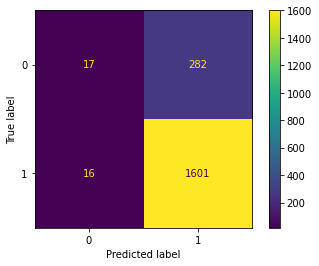

In [77]:
plot_confusion_matrix(lr1, X_test, y_test)

now looking at how handling outliers effects lr3

In [78]:
lr3.fit(X3_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [79]:
print_scores(lr3, X_test, y_test)

precision score:  0.6641929499072357
recall score:  0.8876033057851239
f1 score:  0.7598160594269544
--------------------------------------------------
The percentage of fully_paid predicted correctly:  66.41929499072356
The percentage of not fully_paid predicted correctly:  54.51505016722408


There was no significant difference

# Moving the threshold

In [82]:
find_threshold(lr1, X3_train, y_train)

0.37599409206277734

The find threshold function reveals a low threshold, which will end up predicting 1 for all observations.  Choosing a random threshold of 0.75.

* Remember, this was trained on the X3 training set with outliers handled.

In [83]:
print_scores(lr1, X_test, y_test, threshold=0.75)

precision score:  0.8614718614718615
recall score:  0.8652173913043478
f1 score:  0.8633405639913232
--------------------------------------------------
The percentage of fully_paid predicted correctly:  86.14718614718615
The percentage of not fully_paid predicted correctly:  27.4247491638796


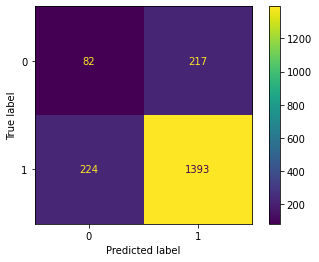

In [85]:
y_preds = get_preds(lr1, X_test, y_test, threshold=0.75)
lr1_cm = confusion_matrix(y_test, y_preds)
cm_disp = ConfusionMatrixDisplay(lr1_cm, display_labels=lr1.classes_)
cm_disp.plot()

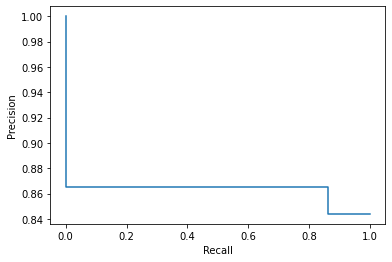

In [86]:
precision, recall, _ = precision_recall_curve(y_test, y_preds)
pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_disp.plot()